In [1]:
# %%
# Author: Genevieve Mortensen, code helped by ChatGPT-4
# Modified: 02/26/2024
# Purpose: Process .wav files into linguistic features, extract Llama 2 text embeddings, and classify using SVC, XGBoost, and Neural Network and LR.

import os
import librosa
import torch
import pandas as pd
import numpy as np
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
from transformers import AutoTokenizer, AutoModel
# from ctransformers import AutoModelForCausalLM
from torch.cuda.amp import autocast
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib.pyplot as plt


# Check to see which device is available
def check_device():
    cuda_flag = torch.cuda.is_available()
    print('torch version = ' + torch.__version__ )
    if cuda_flag:
        device = torch.cuda.current_device()
        device_name = torch.cuda.get_device_name(device)
    else:
        device_name = 'CPU'
    print('CUDA version = ' + torch.version.cuda)
    print('current device = '+ device_name)
    return device


# Use models to transcribe audio to text
def audio_to_text(audio_path, device):
    tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
    model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)  # Move model to GPU
    audio_input, _ = librosa.load(audio_path, sr=16000)
    # Convert audio input to the correct tensor, move it to GPU
    inputs = tokenizer(audio_input, return_tensors="pt", padding="longest")
    input_values = inputs.input_values.to(device)  # Move inputs to GPU
    with torch.no_grad(): # not calculating gradients
        logits = model(input_values).logits # Move logits to GPU
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = tokenizer.batch_decode(predicted_ids.cpu())[0]  # Move tensors to CPU for decoding
    return transcription

#Transcribe training files, return text and labels
def get_training_transcriptions(root_dir, device):
    transcriptions = []
    labels = []  # 0 for 'cn', 1 for 'ad'
    for label_dir in ["cn", "ad"]:
        dir_path = os.path.join(root_dir, label_dir)
        for filename in os.listdir(dir_path):
            if filename.endswith(".wav"):
                audio_path = os.path.join(dir_path, filename)
                transcription = audio_to_text(audio_path, device)
                transcriptions.append(transcription)
                labels.append(0 if label_dir == "cn" else 1)
    print("Training transcriptions and labels acquired")
    labels = np.array(labels)
    return transcriptions, labels

def get_test_transcriptions(test_root_dir, test_labels_path, device):
    transcriptions = []
    file_ids = []
    labels = []
    test_labels_df = pd.read_csv(test_labels_path, header=None)
    label_mapping = {'CN': 0, 'AD': 1}
    test_labels_df['label'] = test_labels_df.iloc[:, 1].map(label_mapping)
    test_labels_df['label'] = test_labels_df['label'].fillna(-1).astype(int)
    file_label_dict = pd.Series(test_labels_df['label'].values, index=test_labels_df.iloc[:, 0].astype(str).str.strip()).to_dict()
    for filename in os.listdir(test_root_dir):
        if filename.endswith(".wav"):
            file_id = filename.split('.')[0].strip()
            audio_path = os.path.join(test_root_dir, filename)
            transcription = audio_to_text(audio_path, device)
            transcriptions.append(transcription)
            file_ids.append(file_id)
            # -1 means we don't have a label for the file and our binary classifiers won't work
            label = file_label_dict.get(file_id, -1)
            labels.append(label)
            if label == -1:
                print(f"Label missing for file_id: {file_id}")
    labels = np.array(labels)
    print("Testing transcriptions, file identifiers, and labels acquired")
    return transcriptions, file_ids, labels

# Extract model 2 embeddings
def get_model_embeddings(texts, model_name, device, batch_size):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        print("Setting pad_token to eos_token.") # no padding token, so we set it to eos_token
        tokenizer.pad_token = tokenizer.eos_token
    model = AutoModel.from_pretrained(model_name).to(device)
    embeddings = []
    embedding_sizes = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad(), autocast(): # not calculating gradients, also autocasting - saves memory and speeds up training
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1) # get embedding from last hidden state
            embeddings.append(batch_embeddings.cpu().numpy())
            embedding_sizes.extend([batch_embeddings.size(1)] * len(batch_texts))
    print("It's working, Spongebob! We got the embeddings!")
    # Return the stacked embeddings and their sizes
    return np.vstack(embeddings), embedding_sizes


/tmp/ipykernel_835653/1043595206.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/gamorten/anaconda3/envs/adresso/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-16 03:00:35.095261: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the env

In [2]:
# SVC
def sv_classifier(train_embeddings, labels, test_embeddings, test_labels):
    
    svc = SVC()
    param_grid = {
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10, 100]
    }

    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
    grid_search.fit(train_embeddings, labels)
    print(f"Best hyperparameters: {grid_search.best_params_}")

    best_model = grid_search.best_estimator_
    cv_results = cross_validate(best_model, train_embeddings, labels, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    svc_predictions = best_model.predict(test_embeddings)
    probabilities = best_model.predict_proba(test_embeddings)

    cv_metrics = {
        'cv_accuracy': round(np.mean(cv_results['test_accuracy']), 3),
        'cv_precision': round(np.mean(cv_results['test_precision']), 3),
        'cv_recall': round(np.mean(cv_results['test_recall']), 3),
        'cv_f1_score': round(np.mean(cv_results['test_f1']), 3),
        'cv_accuracy_std': round(np.std(cv_results['test_accuracy']), 3),
        'cv_precision_std': round(np.std(cv_results['test_precision']), 3),
        'cv_recall_std': round(np.std(cv_results['test_recall']), 3),
        'cv_f1_score_std': round(np.std(cv_results['test_f1']), 3)
    }
    test_metrics = {
        'accuracy': round(accuracy_score(test_labels, svc_predictions), 3),
        'precision': round(precision_score(test_labels, svc_predictions, average='binary'), 3),
        'recall': round(recall_score(test_labels, svc_predictions, average='binary'), 3),
        'f1_score': round(f1_score(test_labels, svc_predictions, average='binary'), 3)
    }
        # Compute AUC scores for each cross-validation fold
    auc_scores = cross_val_score(best_model, train_embeddings, labels, cv=5, scoring='roc_auc')

    # Calculate the mean and std of AUC scores
    auc_mean = np.mean(auc_scores)
    auc_std = np.std(auc_scores)
    print(f"SVC AUC: {auc_mean:.3f} ± {auc_std:.3f}")
    metrics = {**cv_metrics, **test_metrics}
    return metrics, probabilities

In [3]:
#XGBoost Classifier
import time
def xgboost_classifier(train_embeddings, labels, test_embeddings, test_labels):

    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    param_grid = {
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='f1', verbose=1)
    start_train_time = time.time()
    grid_search.fit(train_embeddings, labels)
    end_train_time = time.time()
    print(f"Best XGB hyperparameters: {grid_search.best_params_}")
    
    best_model = grid_search.best_estimator_
    # Compute AUC scores for each cross-validation fold
    auc_scores = cross_val_score(best_model, train_embeddings, labels, cv=5, scoring='roc_auc')

    # Calculate the mean and std of AUC scores
    auc_mean = np.mean(auc_scores)
    auc_std = np.std(auc_scores)
    print(f"XGB AUC: {auc_mean:.3f} ± {auc_std:.3f}")

    cv_results = cross_validate(best_model, train_embeddings, labels, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    start_test_time = time.time()
    xgb_predictions = best_model.predict(test_embeddings)
    end_test_time = time.time()
    
    cv_metrics = {
        'cv_auc_mean': round(auc_mean, 3),
        'cv_auc_std': round(auc_std, 3),
        'cv_accuracy': round(np.mean(cv_results['test_accuracy']), 3),
        'cv_precision': round(np.mean(cv_results['test_precision']), 3),
        'cv_recall': round(np.mean(cv_results['test_recall']), 3),
        'cv_f1_score': round(np.mean(cv_results['test_f1']), 3),
        'cv_accuracy_std': round(np.std(cv_results['test_accuracy']), 3),
        'cv_precision_std': round(np.std(cv_results['test_precision']), 3),
        'cv_recall_std': round(np.std(cv_results['test_recall']), 3),
        'cv_f1_score_std': round(np.std(cv_results['test_f1']), 3)
    }
    test_metrics = {
        'accuracy': round(accuracy_score(test_labels, xgb_predictions), 3),
        'precision': round(precision_score(test_labels, xgb_predictions, average='binary'), 3),
        'recall': round(recall_score(test_labels, xgb_predictions, average='binary'), 3),
        'f1_score': round(f1_score(test_labels, xgb_predictions, average='binary'), 3)
    }
    metrics = {**cv_metrics, **test_metrics}
        # Calculate and print training and testing times
    training_time = end_train_time - start_train_time
    testing_time = end_test_time - start_test_time
    print(f"Training Time: {training_time} seconds")
    print(f"Testing Time: {testing_time} seconds")

    probabilities = best_model.predict_proba(test_embeddings)
    predicted_labels = (xgb_predictions > 0.5).astype(int)
    # end_test_time = time.time()
    
    return metrics, probabilities, predicted_labels


In [4]:
# Logistic Regression classifier
def lr_classifier(train_embeddings, labels, test_embeddings, test_labels):

    log_reg = LogisticRegression(solver='liblinear')
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100]
    }

    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', verbose=1)
    start_train_time = time.time()
    grid_search.fit(train_embeddings, labels)
    end_train_time = time.time()
    print(f"Best hyperparameters: {grid_search.best_params_}")
    
    best_model = grid_search.best_estimator_
    cv_results = cross_validate(best_model, train_embeddings, labels, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    start_test_time = time.time()
    log_reg_predictions = best_model.predict(test_embeddings)
    end_test_time = time.time()

    cv_metrics = {
        'cv_accuracy': round(np.mean(cv_results['test_accuracy']), 3),
        'cv_precision': round(np.mean(cv_results['test_precision']), 3),
        'cv_recall': round(np.mean(cv_results['test_recall']), 3),
        'cv_f1_score': round(np.mean(cv_results['test_f1']), 3),
        'cv_accuracy_std': round(np.std(cv_results['test_accuracy']), 3),
        'cv_precision_std': round(np.std(cv_results['test_precision']), 3),
        'cv_recall_std': round(np.std(cv_results['test_recall']), 3),
        'cv_f1_score_std': round(np.std(cv_results['test_f1']), 3)
    }
    test_metrics = {
        'accuracy': round(accuracy_score(test_labels, log_reg_predictions), 3),
        'precision': round(precision_score(test_labels, log_reg_predictions, average='binary'), 3),
        'recall': round(recall_score(test_labels, log_reg_predictions, average='binary'), 3),
        'f1_score': round(f1_score(test_labels, log_reg_predictions, average='binary'), 3)
    }

    probabilities = best_model.predict_proba(test_embeddings)
        # Compute AUC scores for each cross-validation fold
    auc_scores = cross_val_score(best_model, train_embeddings, labels, cv=5, scoring='roc_auc')

    # Calculate the mean and std of AUC scores
    auc_mean = np.mean(auc_scores)
    auc_std = np.std(auc_scores)
    print(f"LR AUC: {auc_mean:.3f} ± {auc_std:.3f}")
    training_time = end_train_time - start_train_time
    testing_time = end_test_time - start_test_time
    print(f"LR Training Time: {training_time} seconds")
    print(f"LR Testing Time: {testing_time} seconds")

    metrics = {**cv_metrics, **test_metrics}
    return metrics, probabilities

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def nn_classifier(train_embeddings, labels, test_embeddings, test_labels):
    n_splits = 5
    kf = KFold(n_splits=n_splits)
    label_encoder = LabelEncoder()
    all_labels = np.concatenate([labels, test_labels])
    label_encoder.fit(all_labels)
    
    cv_accuracies = []
    cv_precisions = []
    cv_recalls = []
    cv_f1_scores = []
    auc_scores = []
    
    for train_index, val_index in kf.split(train_embeddings):
        train_data, val_data = train_embeddings[train_index], train_embeddings[val_index]
        train_labels, val_labels = labels[train_index], labels[val_index]
        
        train_labels_encoded = to_categorical(label_encoder.transform(train_labels))
        val_labels_encoded = to_categorical(label_encoder.transform(val_labels))
        
        model = Sequential([
            Dense(128, activation='relu', input_shape=(train_embeddings.shape[1],)),
            Dense(64, activation='relu'),
            Dense(len(np.unique(all_labels)), activation='softmax')
        ])
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        
        model.fit(train_data, train_labels_encoded, epochs=10, batch_size=32, verbose=0)
        
        val_predictions = model.predict(val_data)
        val_labels_decoded = np.argmax(val_labels_encoded, axis=-1)
        val_class_predictions = np.argmax(val_predictions, axis=-1)

        # Correctly calculate AUC score using probabilities
        auc_score = roc_auc_score(val_labels_encoded, val_predictions, multi_class='ovo', average='macro')
        auc_scores.append(auc_score)
        
        cv_accuracies.append(accuracy_score(val_labels_decoded, val_class_predictions))
        cv_precisions.append(precision_score(val_labels_decoded, val_class_predictions, average='macro'))
        cv_recalls.append(recall_score(val_labels_decoded, val_class_predictions, average='macro'))
        cv_f1_scores.append(f1_score(val_labels_decoded, val_class_predictions, average='macro'))
    
    cv_metrics = {
        'cv_accuracy': np.mean(cv_accuracies),
        'cv_precision': np.mean(cv_precisions),
        'cv_recall': np.mean(cv_recalls),
        'cv_f1_score': np.mean(cv_f1_scores),
        'cv_auc': np.mean(auc_scores),
        'cv_auc_std': np.std(auc_scores),
        'cv_accuracy_std': np.std(cv_accuracies),
        'cv_precision_std': np.std(cv_precisions),
        'cv_recall_std': np.std(cv_recalls),
        'cv_f1_score_std': np.std(cv_f1_scores)
    }

    labels_encoded = to_categorical(label_encoder.transform(labels))
    test_labels_encoded = to_categorical(label_encoder.transform(test_labels))
    
    model.fit(train_embeddings, labels_encoded, epochs=10, batch_size=32, verbose=0)
    
    probabilities = model.predict(test_embeddings)
    predictions = np.argmax(probabilities, axis=-1)
    test_labels_decoded = np.argmax(test_labels_encoded, axis=-1)
    test_metrics = {
        'accuracy': accuracy_score(test_labels_decoded, predictions),
        'precision': precision_score(test_labels_decoded, predictions, average='binary'),
        'recall': recall_score(test_labels_decoded, predictions, average='binary'),
        'f1_score': f1_score(test_labels_decoded, predictions, average='binary')
    }

    metrics = {**cv_metrics, **test_metrics}
    return metrics, probabilities

In [10]:
from sklearn.metrics import auc


if __name__ == '__main__':

    # # Check device available, offload to GPU if available
    # device = check_device()

    # # Get linguistic features
    #     # training data
    # root_dir = '/home/gamorten/privacyLLM/Healthcare-Chatbots/All_ADReSS_o/train'
    # training_transcriptions, labels = get_training_transcriptions(root_dir, device)
    #      # testing data
    # test_root_dir = '/home/gamorten/privacyLLM/Healthcare-Chatbots/All_ADReSS_o/test'
    # test_labels_path = '/home/gamorten/privacyLLM/Healthcare-Chatbots/groundtruth/combined_labels.csv'
    # test_transcriptions, test_file_ids, test_labels = get_test_transcriptions(test_root_dir, test_labels_path, device)

    # # # Choose your fighter, Llama 2 or Zephyr
    # # model_name = "meta-llama/Llama-2-7b-hf"
    # model_name = "HuggingFaceH4/zephyr-7b-beta"
    # # print(model_name)

    # # # Extract embeddings in batches
    # train_embeddings, train_size = get_model_embeddings(training_transcriptions, model_name=model_name, device=device, batch_size=1)
    # test_embeddings, test_size = get_model_embeddings(test_transcriptions, model_name=model_name, device=device, batch_size=1)
    # print(train_size)
    # print(test_size)

    # train_embeddingsll, train_sizell = get_model_embeddings(training_transcriptions, model_name=model_namell, device=device, batch_size=1)
    # test_embeddingsll, test_sizell = get_model_embeddings(test_transcriptions, model_name=model_namell, device=device, batch_size=1)
    # # print(train_size)
    # print(test_size)

    # Perform classification and get results
#     results = {}
    metricsnn, proba_nn = nn_classifier(train_embeddings, labels, test_embeddings, test_labels)
    metricssv, proba_sv = sv_classifier(train_embeddings, labels, test_embeddings, test_labels)
    metricsxgb, proba_xgb, pred_labels = xgboost_classifier(train_embeddings, labels, test_embeddings, test_labels)
    metricslr, proba_lr = lr_classifier(train_embeddings, labels, test_embeddings, test_labels)

    # metricsll, proba_xgbll, pred_labelsll = xgboost_classifier(train_embeddingsll, labels, test_embeddingsll, test_labels)
    # resultsll, proba_lrll = lr_classifier(train_embeddingsll, labels, test_embeddingsll, test_labels)

    # Save results to csv
    proba_xgb_df = pd.DataFrame(proba_xgb)
    proba_xgb_df.to_csv('/home/gamorten/privacyLLM/Healthcare-Chatbots/results/proba_xgb.csv', index=False)
    proba_lr_df = pd.DataFrame(proba_lr)
    proba_lr_df.to_csv('/home/gamorten/privacyLLM/Healthcare-Chatbots/results/proba_lr.csv', index=False)
    proba_sv_df = pd.DataFrame(proba_sv)
    proba_sv_df.to_csv('/home/gamorten/privacyLLM/Healthcare-Chatbots/results/proba_sv.csv', index=False)
    proba_nn_df = pd.DataFrame(proba_nn)
    proba_nn_df.to_csv('/home/gamorten/privacyLLM/Healthcare-Chatbots/results/proba_nn.csv', index=False)
    # Convert results to pandas dataframe
    # results_df = pd.DataFrame(results).T
    # display(results_df)

    # # Create the table visualization
    # fig, ax = plt.subplots(figsize=(12, 2))  # Adjust figure size as needed
    # ax.axis('tight')
    # ax.axis('off')
    # the_table = ax.table(cellText=results_df.values, colLabels=results_df.columns, rowLabels=results_df.index, cellLoc='center', loc='center')
    # the_table.auto_set_font_size(False)
    # the_table.set_fontsize(12)  # Adjust font size as needed
    # the_table.scale(1.5,1.5)  # Adjust scale as needed to fit your content

    # plt.title('Linguistic Model Performance Metrics', fontsize=12, y=1.1)  # Adjust title and positioning
    # plt.savefig(os.path.join(os.getcwd(), '../results/Zephyr_tester_linguistic_performance.png'))
    # plt.show()
    # print(metrics)


2/2 [==============================] - 0s 2ms/step


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
print(metrics)
print(proba_xgb)
print(pred_labels)

{'cv_accuracy': 0.814, 'cv_precision': 0.834, 'cv_recall': 0.808, 'cv_f1_score': 0.819, 'cv_accuracy_std': 0.068, 'cv_precision_std': 0.093, 'cv_recall_std': 0.049, 'cv_f1_score_std': 0.061, 'accuracy': 0.849, 'precision': 0.847, 'recall': 0.847, 'f1_score': 0.847}
[[0.7045027  0.29549733]
 [0.542577   0.45742294]
 [0.19756204 0.80243796]
 [0.91449535 0.08550464]
 [0.10325831 0.8967417 ]
 [0.28522295 0.71477705]
 [0.9769967  0.0230033 ]
 [0.11070073 0.8892993 ]
 [0.33350402 0.666496  ]
 [0.0750885  0.9249115 ]
 [0.7822528  0.21774724]
 [0.03793174 0.96206826]
 [0.8843478  0.11565223]
 [0.07259351 0.9274065 ]
 [0.9764944  0.02350561]
 [0.39845443 0.6015456 ]
 [0.7683346  0.2316654 ]
 [0.9501287  0.04987135]
 [0.97663623 0.02336374]
 [0.37179327 0.62820673]
 [0.86836255 0.13163744]
 [0.01804739 0.9819526 ]
 [0.01340407 0.9865959 ]
 [0.98025274 0.01974728]
 [0.9570519  0.04294814]
 [0.93627656 0.06372346]
 [0.98906153 0.01093844]
 [0.03499269 0.9650073 ]
 [0.02103442 0.9789656 ]
 [0.89633

In [ ]:
# pull in model prediction labels for each sample in testing
# pull in mmse scores for each sample in testing
# count number of samples with correct predictions for each mmse score
import pandas as pd
import pandas as pd
import seaborn as sns

df = pd.read_csv('/home/gamorten/privacyLLM/Healthcare-Chatbots/groundtruth/combined_labels.csv', header=None)
df21 = pd.read_csv('/home/gamorten/privacyLLM/Healthcare-Chatbots/groundtruth/task2.csv',header=None)
df21 = df21.drop(0)
merged_df = pd.merge(df, df21, on=0)
merged_df.iloc[:, 1] = merged_df.iloc[:, 1].replace({"CN": 0, "AD": 1})
merged_df= merged_df.rename(columns={0: "sample", '1_x': "true_label", '1_y': "mmse"})
# display(merged_df)

# Read the text file
df20 = pd.read_csv('/home/gamorten/privacyLLM/Healthcare-Chatbots/groundtruth/2020Labels.txt', delimiter=';',header=None)
df20 = df20.drop(columns=[1, 2])
df20=df20.drop(0)
df20 = df20.rename(columns={0: "sample", 3: "true_label", 4: "mmse"})

# display(merged_df)
mmse_df = pd.concat([merged_df, df20], ignore_index=True, axis=0)
mmse_df['predicted_labels'] = pred_labels
mmse_df
mmse_df.to_csv('/home/gamorten/privacyLLM/Healthcare-Chatbots/results/mmse_df.csv', index=False)


/tmp/ipykernel_377384/3397462036.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_mmse_df, x='Category', y='mmse', palette='Pastel2')


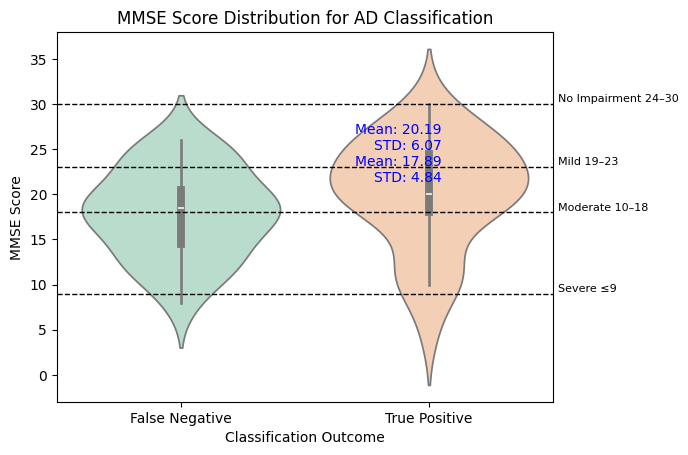

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming mmse_df is your DataFrame and is already loaded

# Define the categorization based on your DataFrame structure
def categorize(row):
    if row['true_label'] == 1 and row['predicted_labels'] == 1:
        return 'True Positive'
    elif row['true_label'] == 1 and row['predicted_labels'] == 0:
        return 'False Negative'
    else:
        return 'Other'

mmse_df['Category'] = mmse_df.apply(categorize, axis=1)

# Filter for 'True Positive' and 'False Negative' categories
filtered_mmse_df = mmse_df[mmse_df['Category'].isin(['True Positive', 'False Negative'])]

# Create the violin plot
sns.violinplot(data=filtered_mmse_df, x='Category', y='mmse', palette='Pastel2')

# MMSE score thresholds and labels
thresholds = [(9, 'Severe ≤9'), (18, 'Moderate 10–18'), (23, 'Mild 19–23'), (30, 'No Impairment 24–30')]
for thr, label in thresholds:
    plt.axhline(y=thr, color='black', linestyle='--', linewidth = 1)
    plt.text(1.52, thr, label, color='black', va='bottom', size = 8)

for category, subset in filtered_mmse_df.groupby('Category')['mmse']:
    mean = subset.mean()
    std = subset.std()
    # Adjust text placement for mean and std, modifying x and y for spacing
    plt.text(1.05, mean + std, f'Mean: {mean:.2f}\nSTD: {std:.2f}', color='blue', va='center', ha='right')


plt.title('MMSE Score Distribution for AD Classification')
plt.xlabel('Classification Outcome')
plt.ylabel('MMSE Score')
plt.show()




119
Sum of the CN side probabilities: 62.39138412475586
Sum of the AD side probabilities: 56.60861587524414


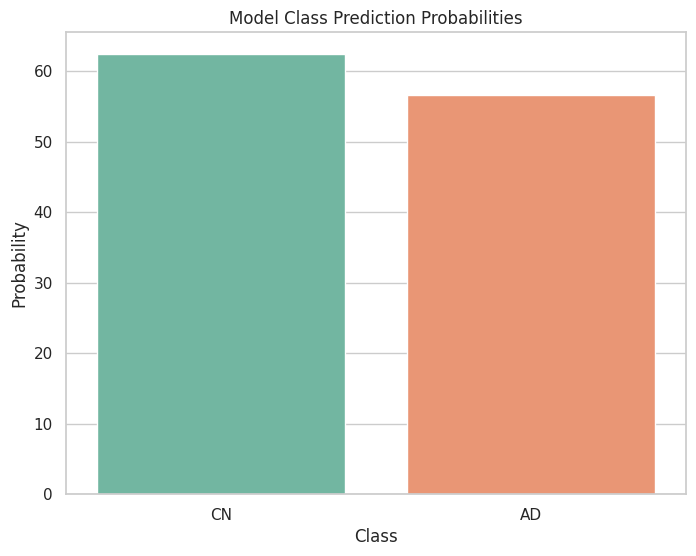

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
print(len(proba))
left_sum = np.sum(proba[:, 0])

# Summing the probabilities on the right side (second column)
right_sum = np.sum(proba[:, 1])

print(f"Sum of the CN side probabilities: {left_sum}")
print(f"Sum of the AD side probabilities: {right_sum}")

# Create a barplot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=["CN", "AD"], y=[left_sum, right_sum], palette="Set2")

# Set labels and title
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("Model Class Prediction Probabilities")

# Show the plot
plt.show()


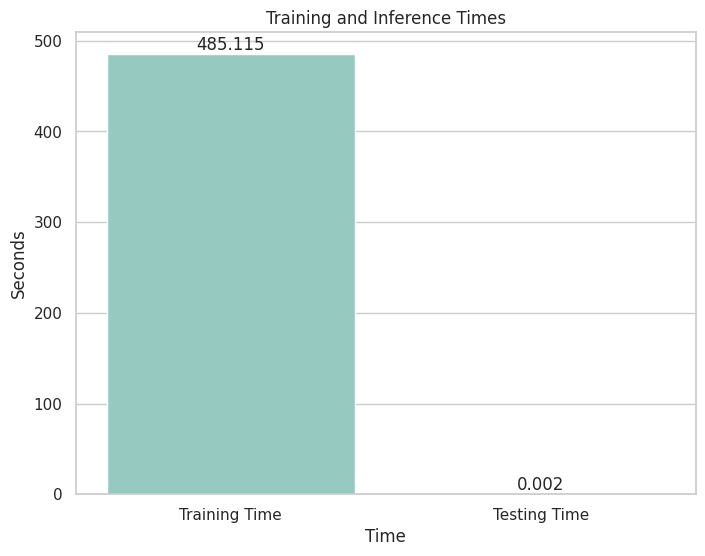

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

times = [485.11467123031616, 0.0018432140350341797]
labels_times = ['Training Time', 'Testing Time']
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels_times, y=times, palette="Set3")
plt.xlabel('Time')
plt.ylabel('Seconds')
plt.title('Training and Inference Times')
# Add the times as text underneath each bar
for i, v in enumerate(times):
    ax.text(i, v, str(round(v, 3)), ha='center', va='bottom')

plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Define paths to your CSV files containing classifier probabilities
csv_files = [
    '/home/gamorten/privacyLLM/Healthcare-Chatbots/results/proba_xgb.csv',
    '/home/gamorten/privacyLLM/Healthcare-Chatbots/results/proba_xgbll.csv',
    '/home/gamorten/privacyLLM/Healthcare-Chatbots/results/proba_lr.csv',
    '/home/gamorten/privacyLLM/Healthcare-Chatbots/results/proba_lrll.csv'
]

classifiers = [
               'Zephyr + XGB',
               'Llama 2 + XGB', 
               'Zephyr + LR', 
               'Llama 2 + LR']
probabilities = [pd.read_csv(file, header=None, usecols=[1]) for file in csv_files]

aucs = []
roc_curves = []
std_devs = [0.048, 0.014,]

for probs in probabilities:
    probs = probs.iloc[:, 0]  # Ensure we're using the second column
    fpr, tpr, _ = roc_curve(test_labels, probs)
    roc_curves.append((fpr, tpr))
    auc = roc_auc_score(test_labels, probs)
    std = np.std(auc)
    aucs.append(auc)

plt.figure(figsize=(10, 8))

for i, ((fpr, tpr), auc, std) in enumerate(zip(roc_curves, aucs, std_devs)):
    plt.plot(fpr, tpr, label=f'{classifiers[i]} (AUC = {auc:.2f} $\pm$ {std})')

plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [119, 120]

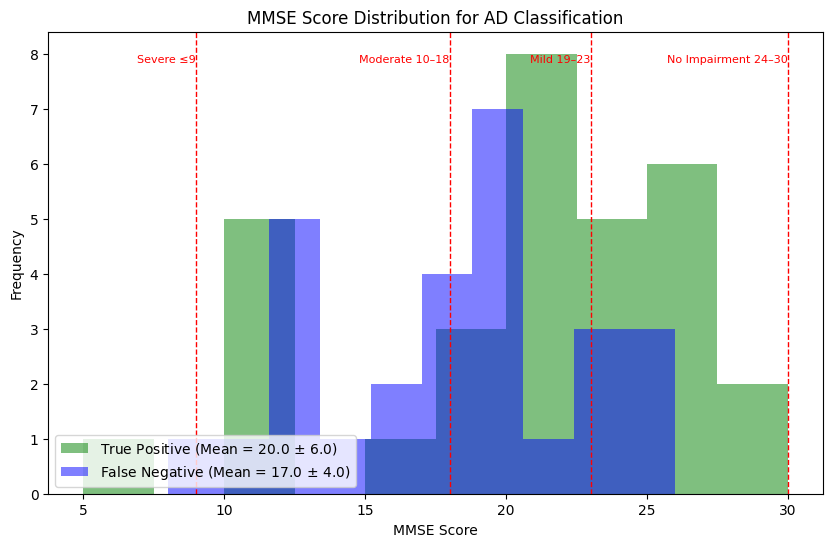

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and is already defined
df = pd.read_csv('/home/gamorten/privacyLLM/Healthcare-Chatbots/results/mmse_df.csv')
# Categorize each sample based on True Positive and False Negative criteria
def categorize(row):
    if row['true_label'] == 1 and row['predicted_labels'] == 1:
        return 'True Positive'
    elif row['true_label'] == 1 and row['predicted_labels'] == 0:
        return 'False Negative'
    else:
        return 'Other'

df['Category'] = df.apply(categorize, axis=1)

# Filter for 'True Positive' and 'False Negative' categories
filtered_df = df[df['Category'].isin(['True Positive', 'False Negative'])]

# Plotting
plt.figure(figsize=(10, 6))

# Function to plot histogram, mean, std and add to legend
def plot_hist_and_stats(data, label, color):
    mean = np.floor(data.mean())
    std = np.floor(data.std())
    
    # Plot histogram
    plt.hist(data, alpha=0.5, bins=10, label=f'{label} (Mean = {mean} $\pm$ {std})', color=color)

# True Positives
plot_hist_and_stats(filtered_df[filtered_df['Category'] == 'True Positive']['mmse'], 'True Positive', 'green')

# False Negatives
plot_hist_and_stats(filtered_df[filtered_df['Category'] == 'False Negative']['mmse'], 'False Negative', 'blue')

# Add vertical lines for MMSE score thresholds
thresholds = [9, 18, 23, 30]
labels = ['Severe ≤9', 'Moderate 10–18', 'Mild 19–23', 'No Impairment 24–30']
for thr, label in zip(thresholds, labels):
    plt.axvline(x=thr, color='red', linestyle='--', linewidth=1)
    plt.text(thr, plt.ylim()[1]*0.95, label, color='red', ha='right', va='top', fontsize=8)

plt.title('MMSE Score Distribution for AD Classification')
plt.xlabel('MMSE Score')
plt.ylabel('Frequency')
plt.legend(loc='lower left')
plt.show()